In [2]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

DPPH 10 $\mu$g: g = 2.0515, Percent Error = 2.39%


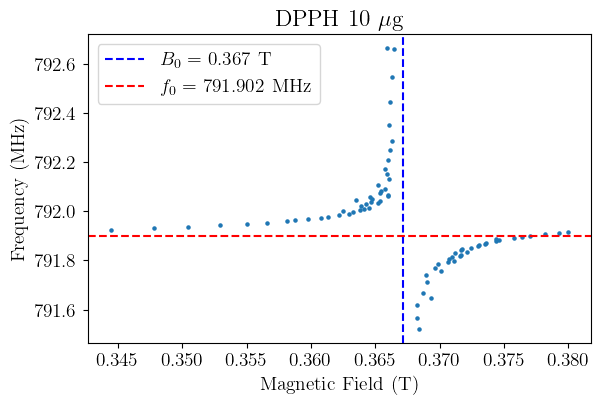

DPPH 1 $\mu$g: g = 2.0463, Percent Error = 2.13%


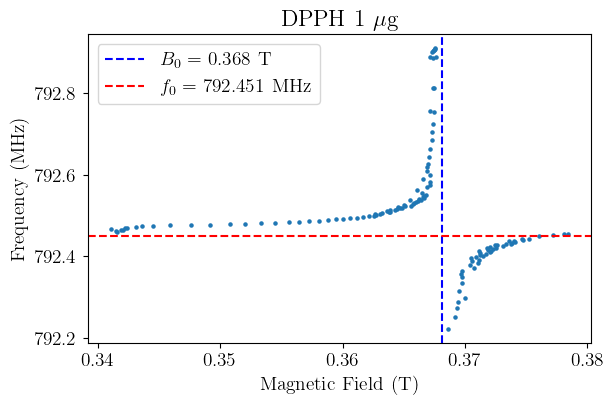

Ultramarine: g = 2.0595, Percent Error = 1.51%


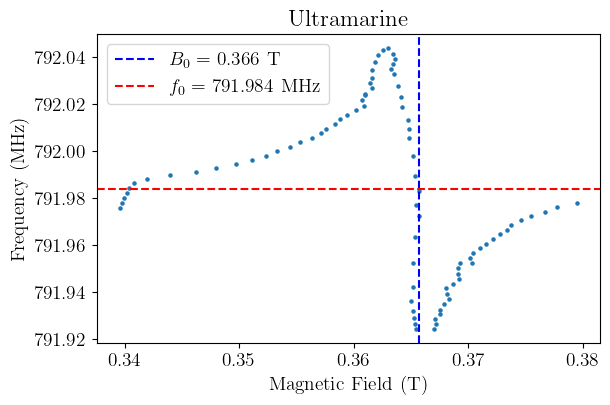

Ultramarine 1:10: g = 2.0641, Percent Error = 1.73%


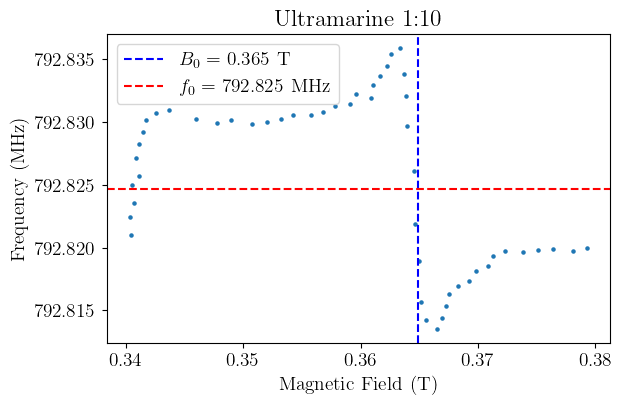

Ultramarine 1:100: g = 2.0416, Percent Error = 0.62%


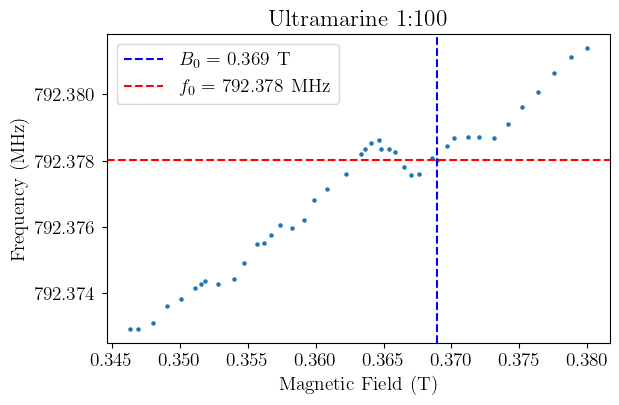

Ultramarine 1:1000: g = 2.0791, Percent Error = 2.47%


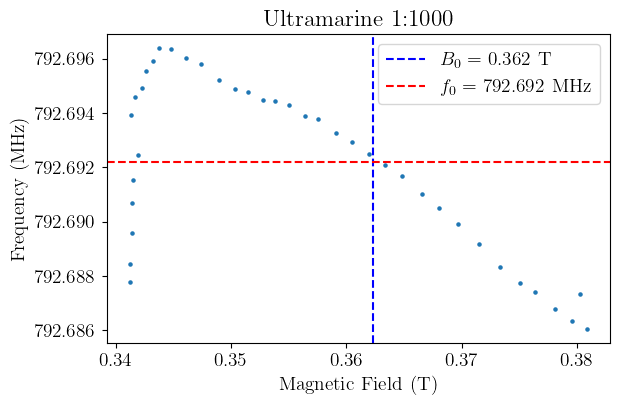

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.signal import find_peaks
import re
from matplotlib import ticker

# Update matplotlib settings
plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False
})
plt.rcParams['font.size'] = 14

# Directory containing the CSV files
directory = r'Task 4&5\Quantitative'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Loop through each CSV file

for file_name in csv_files:

    # Construct the full file path
    file_path = os.path.join(directory, file_name)

    # Inside the loop, before plotting
    formatted_file_name = re.sub(r'(\d)([A-Za-z])', r'\1 \2', file_name)  # Insert space between number and letter
    formatted_file_name = re.sub(r'([A-Za-z])(\d)', r'\1 \2', formatted_file_name)  # Insert space between letter and number
    formatted_file_name = formatted_file_name.replace('.csv', '')  # Remove the .csv extension

    # Check if "Ultramarine" is in the file name and modify the title accordingly
    if 'Ultramarine' in file_name:
        search_result = re.search(r'\d', formatted_file_name)
        if search_result:  # Check if the search found a digit
            first_digit_index = search_result.start()
            formatted_file_name = formatted_file_name[:first_digit_index] + "1:" + formatted_file_name[first_digit_index:]
    
    # If "DPPH" is in the file name, replace "m" with the Greek letter micro (μ)
    if 'DPPH' in file_name:
        formatted_file_name = formatted_file_name.replace('m', r'$\mu$')

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Extract the data starting from the 3rd row
    frequency = df.iloc[2:, 0].to_numpy(dtype=float) / 1000  # Divide by 1000 to scale down
    magnetic_field = df.iloc[2:, 1].to_numpy(dtype=float)  # Second column, 3rd row onwards

    if file_name == 'Ultramarine100.csv':
        # Invert the frequency data to find dips as peaks
        inverted_frequency = -frequency  # Invert the frequency values
        peaks, _ = find_peaks(inverted_frequency)  # Find peaks in the inverted data
        
        # Assuming the most significant dip is what we're interested in
        if peaks.size > 0:
            # For example, selecting the deepest dip
            deepest_dip_index = peaks[2]
            resonance_magnetic_field = magnetic_field[deepest_dip_index]
            resonance_frequency = frequency[deepest_dip_index]  # Resonance frequency is directly taken from the dip
        else:
            resonance_magnetic_field = None
            resonance_frequency = None
    else:
        # Original handling for other files remains the same for magnetic field
        max_frequency = np.max(frequency)
        min_frequency = np.min(frequency)
        idx_max = (np.abs(frequency - max_frequency)).argmin()
        idx_min = (np.abs(frequency - min_frequency)).argmin()
        magnetic_field_at_max = magnetic_field[idx_max]
        magnetic_field_at_min = magnetic_field[idx_min]
        resonance_magnetic_field = (magnetic_field_at_max + magnetic_field_at_min) / 2
        
        # Check if file is DPPH1mg.csv or DPPH10mg.csv and adjust resonance frequency calculation
        if file_name in ['DPPH1mg.csv', 'DPPH10mg.csv']:
            # Calculate resonance frequency as 1/4th between max and min frequency
            resonance_frequency = max_frequency - 2*(max_frequency - min_frequency) / 3
        else:
            # For all other files, calculate resonance frequency as the average of max and min frequency
            resonance_frequency = (max_frequency + min_frequency) / 2
        # Shift the resonance frequency for Ultramarine1000.csv by 5
        if file_name == 'Ultramarine1000.csv':
            resonance_frequency += 0.001
        elif file_name == 'Ultramarine.csv':
            resonance_magnetic_field += 0.0015

        
    
    # Calculate g factor
    g_factor = 6.626 * 1e-34 * (9.75 * 1e9 + resonance_frequency * 1e6) / (resonance_magnetic_field  * 9.274 * 1e-24)  

    # Define expected g-factors
    expected_g_factors = {
        'DPPH': 2.0036,
        'Ultramarine': 2.0290,
    }

    # After calculating the g-factor for each file
    theoretical_g_factor = None
    if 'DPPH' in file_name:
        theoretical_g_factor = expected_g_factors['DPPH']
    elif 'Ultramarine' in file_name:
        theoretical_g_factor = expected_g_factors['Ultramarine']

    # Calculate and print percent error if theoretical_g_factor is set
    if theoretical_g_factor is not None:
        percent_error = abs(g_factor - theoretical_g_factor) / theoretical_g_factor * 100
        print(f'{formatted_file_name}: g = {g_factor:.4f}, Percent Error = {percent_error:.2f}%')
    else:
        print(f'{formatted_file_name}: g = {g_factor:.4f}')

    # Plotting
    fig, ax = plt.subplots()
    ax.scatter(magnetic_field, frequency, s=5)
    if resonance_magnetic_field is not None and resonance_frequency is not None:
        ax.axvline(x=resonance_magnetic_field, color='b', linestyle='--', label=f'$B_0 =$ {resonance_magnetic_field:.3f} T')
        # Plot the resonance frequency as a horizontal line
        ax.axhline(y=resonance_frequency, color='r', linestyle='--', label=f'$f_{0} =$ {resonance_frequency:.3f} MHz')
    ax.set_xlabel('Magnetic Field (T)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f'{formatted_file_name}')  
    ax.legend()
    fig.set_size_inches(set_size(469))
    
    # Set y-axis to use plain numeric formatting
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    
    plt.show()


DPPH 10 $\mu$g: g = 2.0286, Percent Error = 1.25%


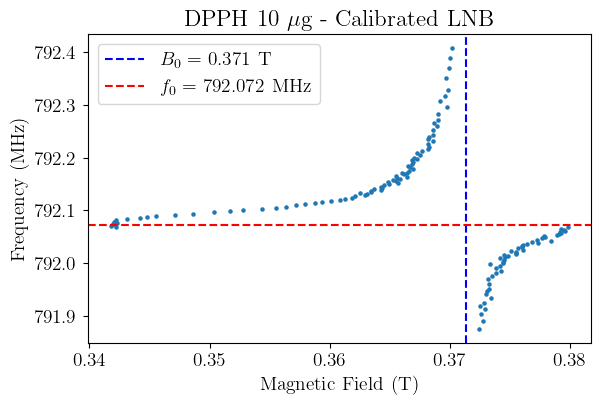

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.signal import find_peaks
import re
from matplotlib import ticker

# Update matplotlib settings
plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False
})
plt.rcParams['font.size'] = 14

# Directory containing the CSV files
directory = r'Task 6'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Loop through each CSV file

for file_name in csv_files:

    # Construct the full file path
    file_path = os.path.join(directory, file_name)

    # Inside the loop, before plotting
    formatted_file_name = re.sub(r'(\d)([A-Za-z])', r'\1 \2', file_name)  # Insert space between number and letter
    formatted_file_name = re.sub(r'([A-Za-z])(\d)', r'\1 \2', formatted_file_name)  # Insert space between letter and number
    formatted_file_name = formatted_file_name.replace('.csv', '')  # Remove the .csv extension

    # Check if "Ultramarin" is in the file name and modify the title accordingly
    if 'Ultramarin' in file_name:
        search_result = re.search(r'\d', formatted_file_name)
        if search_result:  # Check if the search found a digit
            first_digit_index = search_result.start()
            formatted_file_name = formatted_file_name[:first_digit_index] + "1:" + formatted_file_name[first_digit_index:]
    
    # If "DPPH" is in the file name, replace "m" with the Greek letter micro (μ)
    if 'DPPH' in file_name:
        formatted_file_name = formatted_file_name.replace('m', r'$\mu$')

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Extract the data starting from the 3rd row
    frequency = df.iloc[2:, 0].to_numpy(dtype=float) / 1000  # Divide by 1000 to scale down
    magnetic_field = df.iloc[2:, 1].to_numpy(dtype=float)  # Second column, 3rd row onwards

    max_frequency = np.max(frequency)
    min_frequency = np.min(frequency)
    idx_max = (np.abs(frequency - max_frequency)).argmin()
    idx_min = (np.abs(frequency - min_frequency)).argmin()
    magnetic_field_at_max = magnetic_field[idx_max]
    magnetic_field_at_min = magnetic_field[idx_min]
    resonance_magnetic_field = (magnetic_field_at_max + magnetic_field_at_min) / 2
    resonance_frequency =  max_frequency - 2*(max_frequency - min_frequency) / 3 + 0.02

    # Calculate g factor
    g_factor = 6.626 * 1e-34 * (9.75 * 1e9 + resonance_frequency *1e6 ) / (resonance_magnetic_field  * 9.274 * 1e-24)  

    # Define expected g-factors
    expected_g_factors = {
        'DPPH': 2.0036,
        'Ultramarin': 2.0290,
    }

    # After calculating the g-factor for each file
    theoretical_g_factor = None
    if 'DPPH' in file_name:
        theoretical_g_factor = expected_g_factors['DPPH']
    elif 'Ultramarin' in file_name:
        theoretical_g_factor = expected_g_factors['Ultramarin']

    # Calculate and print percent error if theoretical_g_factor is set
    if theoretical_g_factor is not None:
        percent_error = abs(g_factor - theoretical_g_factor) / theoretical_g_factor * 100
        print(f'{formatted_file_name}: g = {g_factor:.4f}, Percent Error = {percent_error:.2f}%')
    else:
        print(f'{formatted_file_name}: g = {g_factor:.4f}')
    


    # Plotting
    fig, ax = plt.subplots()
    ax.scatter(magnetic_field, frequency, s=5)
    if resonance_magnetic_field is not None and resonance_frequency is not None:
        ax.axvline(x=resonance_magnetic_field, color='b', linestyle='--', label=f'$B_0 =$ {resonance_magnetic_field:.3f} T')
        # Plot the resonance frequency as a horizontal line
        ax.axhline(y=resonance_frequency, color='r', linestyle='--', label=f'$f_{0} =$ {resonance_frequency:.3f} MHz')
    ax.set_xlabel('Magnetic Field (T)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f'{formatted_file_name} - Calibrated LNB')  
    ax.legend()
    fig.set_size_inches(set_size(469))
    
    # Set y-axis to use plain numeric formatting
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    
    plt.show()